In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import factorial

In [2]:
def bayesian_decoding_2d(k, xax, yax, ratemaps, dt, epsilon=1e-7):
    """
    This function takes one time bin and the spike counts of all neurons within, and decodes the x, y positions
    from the ratemaps.

    Parameters
    ----------
    k : ndarray or list
        1-d numpy array with shape (num_neurons, ). Number of spike counts of each neuron within a time bin.
    xax : ndarray
        1-d numpy array with shape (num_xbins, ). The axis of the x position bins.
    yax : ndarray
        1-d numpy array with shape (num_ybins, ). The axis of the y position bins.
    ratemaps : ndarray
        2-D numpy array with shape (num_neurons, num_xbins, num_ybins). Instantaneous firing rate
    dt : float
        size of the time bin.
    epsilon : float
        A small value for numerical stability in log(P)

    Returns
    -------
    logL : ndarray
        2-d array with shape (num_xbins, num_ybins). Loglikelihood.
    xML : float
        The x-coordinate of maximum likelihood estimate of the position.
    yML : float
        The y-coordinate of maximum likelihood estimate of the position.
    """

    num_neurons = ratemaps.shape[0]
    num_xbins, num_ybins = ratemaps.shape[1], ratemaps.shape[2]
    assert ratemaps.shape[1] == xax.shape[0]
    assert ratemaps.shape[2] == yax.shape[0]

    logL = np.zeros((num_xbins, num_ybins))
    for i in range(num_neurons):
        mean_event_nums = ratemaps[i, :, :] * dt + epsilon
        out = k[i] * np.log(mean_event_nums) - mean_event_nums - factorial(k[i])
        logL += out

    maxid1D_logL = np.argmax(logL)
    maxid2D_logL = np.unravel_index(maxid1D_logL, logL.shape)
    xML = xax[maxid2D_logL[0]]
    yML = yax[maxid2D_logL[1]]
    return logL, xML, yML

In [13]:
# Data generation for decoding.
def tuning(x, xc, y, yc):
    # Positional tuning
    return np.exp( ((x-xc)**2 + (y-yc)**2) * -1) * 5
dx, dy = 0.1, 0.1
xax = np.arange(-5, 5+dx, dx)
yax = np.arange(-5, 5+dy, dy)
xx, yy = np.meshgrid(xax, yax, indexing='ij')

num_neurons = 100
np.random.seed(0)
field_x = np.linspace(-5, 5, num_neurons)
field_y = np.zeros(num_neurons)
sd_ind = 1/dx
ratemaps = np.zeros((num_neurons, xax.shape[0], yax.shape[0]))

for i in range(num_neurons):
    ratemaps[i, :, :] = tuning(xx, field_x[i], yy, field_y[i])

dt = 0.01
trajt = np.arange(0, 2+dt, dt)
trajx = np.linspace(-5, 5, trajt.shape[0])
trajy = np.zeros(trajx.shape[0])
k_all = np.zeros((trajt.shape[0], num_neurons))
for i in range(trajt.shape[0]):
    x, y = trajx[i], trajy[i]

    for j in range(num_neurons):
        xc, yc = field_x[j], field_y[j]
        rate = tuning(x, xc, y, yc)
        mean_event_num = rate * dt
        np.random.seed(i*j+j)
        k_all[i, j] = np.random.poisson(mean_event_num)



In [10]:
yy

array([[-5. , -4.8, -4.6, ...,  4.6,  4.8,  5. ],
       [-5. , -4.8, -4.6, ...,  4.6,  4.8,  5. ],
       [-5. , -4.8, -4.6, ...,  4.6,  4.8,  5. ],
       ...,
       [-5. , -4.8, -4.6, ...,  4.6,  4.8,  5. ],
       [-5. , -4.8, -4.6, ...,  4.6,  4.8,  5. ],
       [-5. , -4.8, -4.6, ...,  4.6,  4.8,  5. ]])

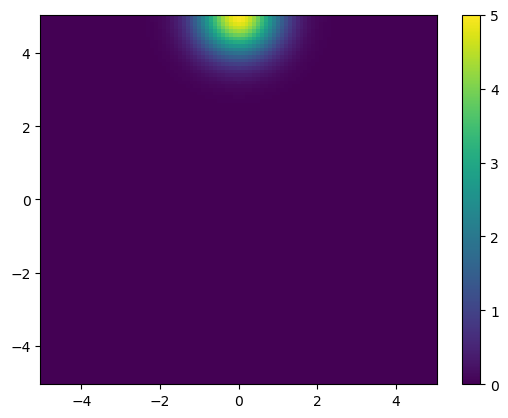

In [14]:
# Example firing map
plt.pcolormesh(xax, yax, ratemaps[99, :, :])
plt.colorbar()

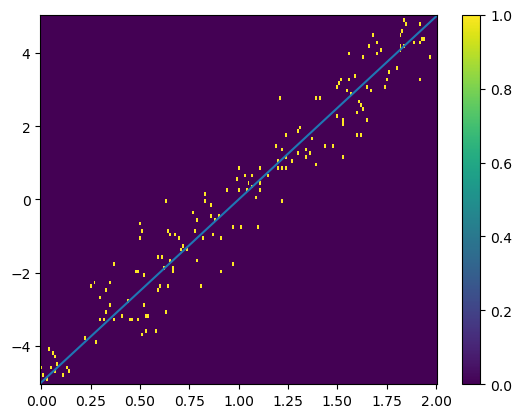

In [16]:
# Example spike counts / event counts.
# Calcium trace data might use something else. But classical decoding needs integer spike counts with poisson distribution
fig, ax = plt.subplots()
im = ax.pcolormesh(trajt, field_x, k_all.T)
plt.colorbar(im)
ax.plot(trajt, trajx)

In [17]:
# Start decoding based on spike counts
all_logL = np.zeros((trajt.shape[0], xax.shape[0], yax.shape[0]))
all_xML = np.zeros((trajt.shape[0],))
all_yML = np.zeros((trajt.shape[0],))
epsilon = 1e-7

for i in range(trajt.shape[0]):
    k = k_all[i, :]
    logL, xML, yML = bayesian_decoding_2d(k, xax, yax, ratemaps, dt, epsilon=1e-7)
    all_logL[i, :, :] = logL
    all_xML[i] = xML
    all_yML[i] = yML

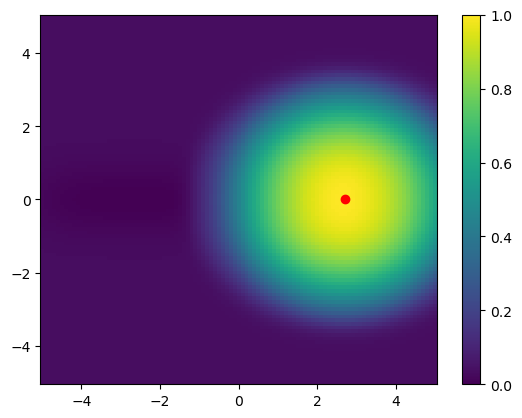

In [18]:
# Decoded example
example_id = 150
plt.pcolormesh(xax, yax, all_logL[example_id, :, :].T)
plt.scatter(all_xML[example_id], all_yML[example_id], c='r', zorder=3)
plt.colorbar()

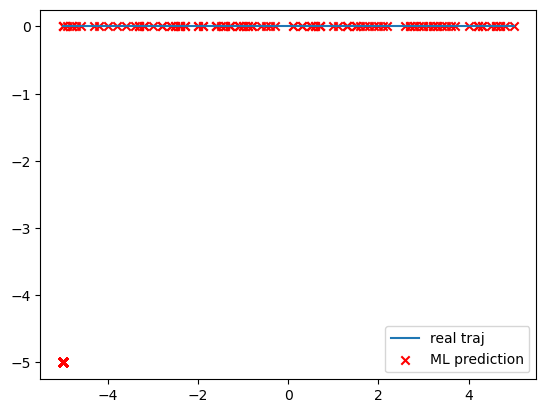

In [19]:
# Plot prediction vs. data
plt.plot(trajx, trajy, label='real traj')
plt.scatter(all_xML, all_yML, marker='x', color='r', label='ML prediction')
plt.legend()